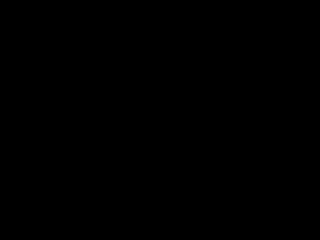

Webcam ready!
Saved image: ./captured_images/photo_0.jpeg
Saved image: ./captured_images/photo_1.jpeg
Saved image: ./captured_images/photo_2.jpeg
Saved image: ./captured_images/photo_3.jpeg
Saved image: ./captured_images/photo_4.jpeg


In [1]:
import cv2
from IPython.display import display, Image
import time
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image as PILImage
import os

# Initialize the camera using OpenCV.
camera = cv2.VideoCapture(0)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)
display_handle = display(None, display_id=True)
if not camera.isOpened():
    print("Error: Could not open webcam.")
else:
    print('Webcam ready!')

# Load model and checkpoint
num_classes = 2
checkpoint = './ryan_albaro_uribe_resnet34.pth'
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
# model.load_state_dict(torch.load(checkpoint))

# using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.436, 0.385, 0.345], std=[0.296, 0.270, 0.261])  # Normalize
])

# Set model to evaluation mode
model.eval()

# Create a directory to save photos if it doesn't exist
output_dir = './input'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Camera capture loop
with torch.no_grad():
    image_count = 0  # Counter for saved images
    while camera.isOpened():
        try:
            # Read the camera image
            ret, frame = camera.read()
            if not ret:
                print("Failed to capture frame")
                break

            # Convert to PIL Image for transformations
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = PILImage.fromarray(frame_rgb)

            # Apply transformations
            transformed_frame = transform(pil_image).unsqueeze(0).to(device)

            # Get the prediction
            pred = model(transformed_frame)
            pred_class = pred.argmax(1).item()  # Get the predicted class index

            # Save the frame to the output directory every 5 seconds
            image_filename = f"{output_dir}/photo_{image_count}.jpeg"
            cv2.imwrite(image_filename, frame)
            print(f"Saved image: {image_filename}")

            # Increment the image count for the next save
            image_count += 1

            # Display the frame in the notebook (optional)
            _, jpeg_frame = cv2.imencode('.jpeg', frame)
            display_handle.update(Image(data=jpeg_frame.tobytes()))

            # Wait for 5 seconds before capturing the next image
            time.sleep(2)

        except KeyboardInterrupt:
            break

# Clean up camera resources
camera.release()
cv2.destroyAllWindows()
